In [1]:
from discriminator.discriminator_wrapper import DiscriminatorWrapper
from coco_utils import load_coco_data_struct, load_coco_data
import tensorflow as tf
import numpy as np

### Load data

In [2]:
vocab_data, train_data, val_data = load_coco_data_struct(base_dir="datasets/self_process", 
                                                         source_image_features='block5_conv4',
                                                        is_caption_separated=True)


Loaded vocab data.
Embedding <class 'numpy.ndarray'> (2593, 304) float64
Word to index <class 'dict'> 2593
Index to word <class 'list'> 2593

Loaded train data.
Captions <class 'numpy.ndarray'> (407521, 19) int64
Image indices <class 'numpy.ndarray'> (407521,) int64
Image features <class 'numpy.ndarray'> (82783, 2, 2, 100) float64
Image urls <class 'numpy.ndarray'> (82783,) <U71

Loaded val data.
Captions <class 'numpy.ndarray'> (202654, 51) int64
Image indices <class 'numpy.ndarray'> (202654,) int64
Image features <class 'numpy.ndarray'> (40504, 2, 2, 100) float64
Image urls <class 'numpy.ndarray'> (40504,) <U67


In [3]:
di = DiscriminatorWrapper(train_data, val_data, vocab_data)

['<START> two red double-decker buses wait by the curb <END>']


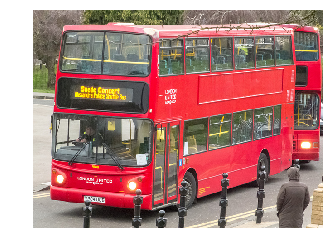

['<START> a living room furnished with couches lamps and art <END>']


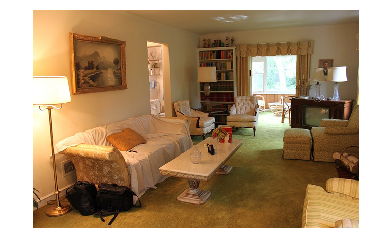

['<START> baked food items served in dishes on blue colored table <END>']


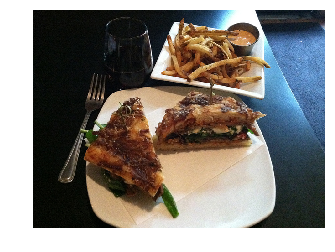

['<START> a number of pieces of broccoli piled together with ice <END>']


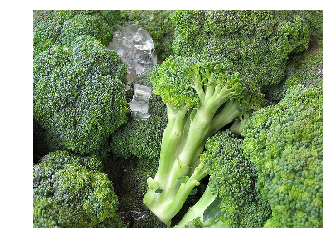

['<START> a bus is driving down a wooded road <END>']


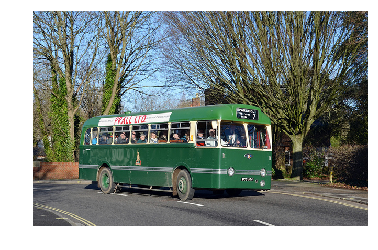

In [5]:
index = np.random.randint(0, train_data.data_size, 5)
for (cap, im) in zip(train_data.captions_in_word_idx[index], train_data.image_idx[index]):
    print(vocab_data.decode_captions(np.array([cap])))
    di.show_image_by_image_idxs(train_data, [im])

In [9]:
(_, h, img_width, img_feat_dim) = train_data.image_features.shape
assert h == img_width

# existing
dim_hidden = 512
num_ctx = img_width * img_width
cap_len = train_data.max_caption_len  
embedding_dim = 300

fake_caption_embedding = np.random.normal(0,1 , (2,cap_len,embedding_dim))
fake_image_features = train_data.image_features[0:2]


In [10]:
from layer_utils import affine_transform, build_mlp

tf.reset_default_graph()
sy_deep_image = tf.placeholder(shape=[None, img_width, img_width, img_feat_dim], name="deep_image", dtype=tf.float32)
sy_annotation = tf.reshape(sy_deep_image, [-1, num_ctx, img_feat_dim])
sy_caption_embedding = tf.placeholder(shape=[None, cap_len, embedding_dim], name="embedding", dtype=tf.float32)

init_hidden_state = affine_transform(tf.reduce_mean(sy_annotation, axis=1), dim_hidden, "init_h")
init_cell_state = affine_transform(tf.reduce_mean(sy_annotation, axis=1), dim_hidden, "init_c")
state = tf.nn.rnn_cell.LSTMStateTuple(init_cell_state, init_hidden_state)
output = init_hidden_state

with tf.variable_scope("lstm") as scope:
    
    output_seq = []
    for idx in range(cap_len - 1):
        prev_ctx = affine_transform(output, img_feat_dim, scope="prev_to_context")
        prev_ctx = tf.tile(tf.expand_dims(prev_ctx,1), [1, num_ctx, 1])
        
        annotation = affine_transform(sy_annotation, img_feat_dim, scope="ann_to_ann")
        ctx = tf.concat([prev_ctx, annotation], axis=2)
        ctx = tf.squeeze(build_mlp(ctx, 1, "context"), axis=2)
        alpha = tf.nn.softmax(ctx)
        
        weighted_ctx = tf.reduce_mean(sy_annotation * tf.expand_dims(alpha, 2), axis=1)
        
        lstm = tf.nn.rnn_cell.LSTMCell(dim_hidden, initializer=tf.random_normal_initializer(stddev=0.03)) 

        word = sy_caption_embedding[:, idx + 1]
        output, state = lstm(tf.concat([word, weighted_ctx], axis=1) , state)
        
        output_seq.append(output)
        scope.reuse_variables()
    
    final_output = tf.stack(output_seq, axis=1)


In [14]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    res = sess.run(final_output, feed_dict={
        sy_deep_image: fake_image_features, 
        sy_caption_embedding: fake_caption_embedding})

In [18]:
res.shape

(2, 18, 512)